# Months with best weather

* San Francisco = 10
* Gainesville, FL = 4, 5
* Seattle = 6, 7, 8
* Austin, TX = 4, 5, 10
* Chicago = 7, 8

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import datetime

In [2]:
feats = []
f = open('../features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

T(°F) = T(K) × 9/5 - 459.67

[This source](https://www.energyvanguard.com/blog/24336/The-4-Factors-of-Comfort) indicates that it's comfortable if the temperature is between 70 and 80 degrees Fahrenheit, and the humidity between 30% and 70%.

In [10]:
def convert_temperature(k):
    return k * 9 / 5 - 459.67

In [24]:
def comfort_index(df):
    """
    The smaller the better, 0 is the best
    """
    mean_wind = 6.85
    humidity = df['Humidity']
    temperature = df['Temperature']
    wind = df['Wind']
    
    if temperature >= 70 and temperature <= 80 and humidity >= 30 and humidity <= 70:
        if wind <= mean_wind:  # comfortable wind
            return 0
        else:
            return wind - mean_wind  # strong wind but still comfortable
    
    index = 0
    
    if temperature < 70:  # cold
        index = 70 - temperature
        if wind > mean_wind:
            index += wind - mean_wind
    else:  # hot
        index = temperature - 80
        if wind > mean_wind:  # wind would help the hot temp
            index -= wind - mean_wind
    
    if humidity < 30:
        index += 30 - humidity
    elif humidity > 70:
        index += humidity - 70
    
    return index

In [3]:
%%time

df = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion11:13030/nam_s/*')
df = df.select([
    'Timestamp',
    'Geohash',
    col('relative_humidity_zerodegc_isotherm').alias('Humidity'),
    col('temperature_surface').alias('Temperature'),
    col('surface_wind_gust_surface').alias('Wind'),
])  # Select columns needed to speed up the process
df.show(10)

+-------------+------------+--------+-----------+---------+
|    Timestamp|     Geohash|Humidity|Temperature|     Wind|
+-------------+------------+--------+-----------+---------+
|1438754400000|f2jv9b26m9kp|    57.0|  281.25854| 6.131471|
|1439748000000|c0r6zjuefu2p|    17.0|  289.06982| 5.616594|
|1440547200000|f26y8y56pn7z|    84.0|  285.27368| 5.903287|
|1440460800000|dmbnfcepz1xb|    84.0|  302.63672|4.2784443|
|1440568800000|cdqkdn3sbhup|    44.0|   283.2461|4.6272426|
|1440871200000|f096j2kw7980|    19.0|  284.24902| 5.413671|
|1439920800000|d7b784wu2p0p|    40.0|  314.55762|3.9015393|
|1439510400000|b9vgvezq7y00|    49.0|  286.62476|5.1333885|
|1440439200000|9nqc8pzjhkrz|    25.0|  292.12012| 7.613288|
|1440396000000|dkz0u7vf1ghp|    57.0|  303.27466|6.7580414|
+-------------+------------+--------+-----------+---------+
only showing top 10 rows

CPU times: user 44.5 ms, sys: 19.3 ms, total: 63.7 ms
Wall time: 3min 26s


In [ ]:
%%time

df = df.withColumn('Timestamp', df['Timestamp'] / 1000)\
    .withColumn('Month', month(from_unixtime('Timestamp').cast(DateType())))

In [5]:
df.describe(['Humidity','Temperature','Wind']).show()

+-------+------------------+------------------+-----------------+
|summary|          Humidity|       Temperature|             Wind|
+-------+------------------+------------------+-----------------+
|  count|         108000000|         108000000|        108000000|
|   mean|52.955067148148146| 287.3189240607151|6.847670909482179|
| stddev|31.932329176954795|14.102389431625761|4.462058868522337|
|    min|               1.0|         218.99284|     7.1111065E-4|
|    max|             100.0|         330.67432|         55.79795|
+-------+------------------+------------------+-----------------+



# 1.  **San Francisco**: "9q8y"

![SF](img/SF.png)

In [6]:
%%time

df.createOrReplaceTempView("NAM_S")
avg = spark.sql(
    '''
    SELECT
        Month,
        AVG(Humidity) AS Humidity,
        AVG(Temperature) AS Temperature,
        AVG(Wind) AS Wind
    FROM NAM_S
    WHERE Geohash like "9q8y%"
    GROUP BY Month
    '''
)

avg.show()

+-----+------------------+------------------+------------------+
|Month|          Humidity|       Temperature|              Wind|
+-----+------------------+------------------+------------------+
|   12| 49.02923976608187|286.42983473392957|5.4680921042348904|
|    1| 29.08839779005525| 286.3078034964714| 2.845470394877439|
|    6|22.534391534391535|  288.054439484127| 4.489029953719447|
|    3| 23.35593220338983| 287.5729620119946|3.7010064709321253|
|    5|27.502538071065988|285.93894005789974| 5.767601351144955|
|    9| 27.15819209039548|291.33187124823445|4.3727134156361815|
|    4| 33.30978260869565| 285.6995541116466| 5.957776742136997|
|    8| 24.09039548022599|  291.962221652101| 4.196229055102935|
|    7| 35.19209039548023|290.96086301641947| 4.693868951608906|
|   10| 33.37234042553192|291.24358952299076|3.4720824297438275|
|   11| 34.93582887700535|  287.045389104017| 4.612026401382079|
|    2|26.074074074074073|287.36073001814475| 4.645757689888095|
+-----+------------------

In [15]:
# Convert to Pandas dataframe
avg_pandas_df = avg.toPandas()

In [16]:
avg_pandas_df.to_pickle('/home4/csung4/sf.pickle')

In [17]:
avg_pandas_df = pd.read_pickle('/home4/csung4/sf.pickle')

In [18]:
avg_pandas_df.Temperature = convert_temperature(avg_pandas_df.Temperature)
avg_pandas_df

,Month,Humidity,Temperature,Wind
0,12,49.029240,55.903703,5.468092
1,1,29.088398,55.684046,2.845470
2,6,22.534392,58.827991,4.489030
3,3,23.355932,57.961332,3.701006
4,5,27.502538,55.020092,5.767601
5,9,27.158192,64.727368,4.372713
6,4,33.309783,54.589197,5.957777
7,8,24.090395,65.861999,4.196229
8,7,35.192090,64.059553,4.693869
9,10,33.372340,64.568461,3.472082


In [26]:
avg_pandas_df['comfort_index'] = avg_pandas_df.apply(comfort_index, axis=1)
avg_pandas_df.set_index(['Month'])
avg_pandas_df.sort_values('Month', inplace=True)
avg_pandas_df

,Month,Humidity,Temperature,Wind,comfort_index
1,1,29.088398,55.684046,2.845470,15.227556
11,2,26.074074,57.579314,4.645758,16.346612
3,3,23.355932,57.961332,3.701006,18.682736
6,4,33.309783,54.589197,5.957777,15.410803
4,5,27.502538,55.020092,5.767601,17.477370
2,6,22.534392,58.827991,4.489030,18.637617
8,7,35.192090,64.059553,4.693869,5.940447
7,8,24.090395,65.861999,4.196229,10.047606
5,9,27.158192,64.727368,4.372713,8.114440
9,10,33.372340,64.568461,3.472082,5.431539


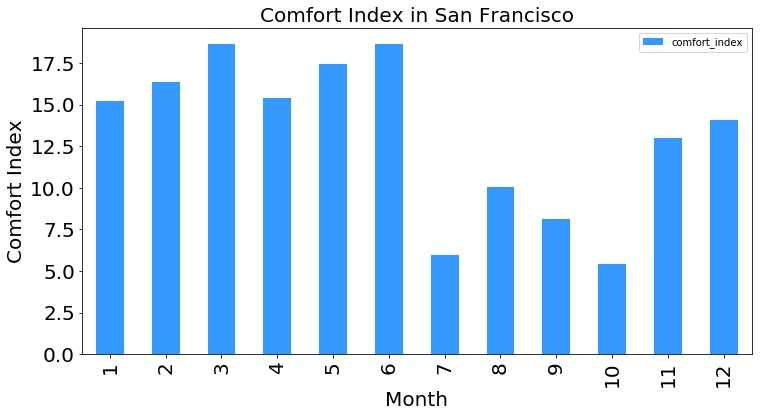

In [27]:
%matplotlib inline

ax = avg_pandas_df.plot(
    kind='bar',
    figsize=(12, 6),
    x='Month',
    y='comfort_index',
    fontsize = 20,
    color='#3399ff',
)
ax.set_xlabel('Month', fontsize = 20)
ax.set_ylabel('Comfort Index', fontsize = 20)
ax.set_title('Comfort Index in San Francisco', fontsize = 20)
plt.show()

* The smaller the comfort index is, the more comfortable it is.
* From our result, the best month to visit San Francisco is October.
* U.S. News indicates that the best time to visit San Francisco is between September and November. [source](https://travel.usnews.com/San_Francisco_CA/When_To_Visit/)

# 2.  **Gainesville, FL**: "djm2"

![Gainesville](img/Gainesville.png)

In [28]:
%%time

df.createOrReplaceTempView("NAM_S")
avg = spark.sql(
    '''
    SELECT
        Month,
        AVG(Humidity) AS Humidity,
        AVG(Temperature) AS Temperature,
        AVG(Wind) AS Wind
    FROM NAM_S
    WHERE Geohash like "djm2%"
    GROUP BY Month
    '''
)

avg.show()

+-----+------------------+------------------+------------------+
|Month|          Humidity|       Temperature|              Wind|
+-----+------------------+------------------+------------------+
|   12|23.175257731958762|293.93394171331346| 4.193663595570731|
|    1|34.638297872340424| 286.0075034283577|3.6169779124729176|
|    6| 50.14678899082569|  301.771014012328|2.3378457632086693|
|    3|29.288659793814432| 292.5560425433916| 4.163969370200462|
|    5| 34.42045454545455|299.42675746570933| 3.117915778674863|
|    9|54.027522935779814| 300.1188494481078|3.1265861452172654|
|    4| 41.53191489361702|297.04061662389876| 4.053455001179208|
|    8| 53.39622641509434| 302.4982794995578|2.3989840951168313|
|    7| 57.16494845360825| 302.4940349146263|2.2881644497212674|
|   10|              18.6| 295.1717812278054|3.6506511493162677|
|   11|29.931372549019606|293.63313652487363| 3.796104420926057|
|    2|38.679611650485434| 283.5030884974211| 5.287655468704631|
+-----+------------------

In [29]:
# Convert to Pandas dataframe
avg_pandas_df = avg.toPandas()

In [30]:
avg_pandas_df.to_pickle('/home4/csung4/gnv.pickle')

In [31]:
avg_pandas_df = pd.read_pickle('/home4/csung4/gnv.pickle')

In [32]:
avg_pandas_df.Temperature = convert_temperature(avg_pandas_df.Temperature)
avg_pandas_df

,Month,Humidity,Temperature,Wind
0,12,23.175258,69.411095,4.193664
1,1,34.638298,55.143506,3.616978
2,6,50.146789,83.517825,2.337846
3,3,29.288660,66.930877,4.163969
4,5,34.420455,79.298163,3.117916
5,9,54.027523,80.543929,3.126586
6,4,41.531915,75.003110,4.053455
7,8,53.396226,84.826903,2.398984
8,7,57.164948,84.819263,2.288164
9,10,18.600000,71.639206,3.650651


In [33]:
avg_pandas_df['comfort_index'] = avg_pandas_df.apply(comfort_index, axis=1)
avg_pandas_df.set_index(['Month'])
avg_pandas_df.sort_values('Month', inplace=True)
avg_pandas_df

,Month,Humidity,Temperature,Wind,comfort_index
1,1,34.638298,55.143506,3.616978,14.856494
11,2,38.679612,50.635559,5.287655,19.364441
3,3,29.288660,66.930877,4.163969,3.780464
6,4,41.531915,75.003110,4.053455,0.000000
4,5,34.420455,79.298163,3.117916,0.000000
2,6,50.146789,83.517825,2.337846,3.517825
8,7,57.164948,84.819263,2.288164,4.819263
7,8,53.396226,84.826903,2.398984,4.826903
5,9,54.027523,80.543929,3.126586,0.543929
9,10,18.600000,71.639206,3.650651,3.039206


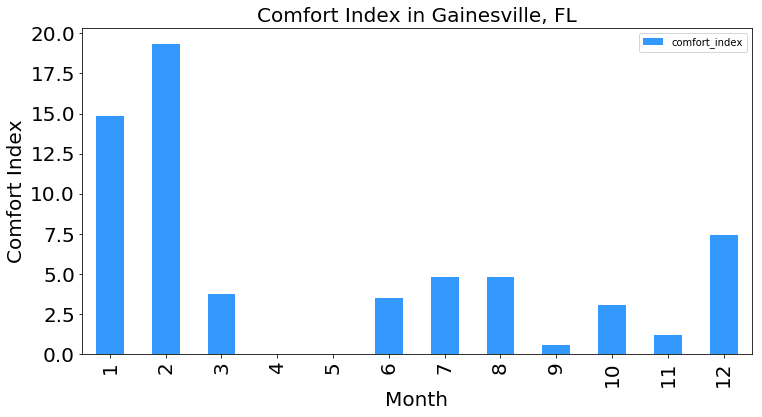

In [34]:
%matplotlib inline

ax = avg_pandas_df.plot(
    kind='bar',
    figsize=(12, 6),
    x='Month',
    y='comfort_index',
    fontsize = 20,
    color='#3399ff',
)
ax.set_xlabel('Month', fontsize = 20)
ax.set_ylabel('Comfort Index', fontsize = 20)
ax.set_title('Comfort Index in Gainesville, FL', fontsize = 20)
plt.show()

* The best month to visit Gainesville, FL is April or May.
* These two websites indicates that the time around April is the best time to visit. [source1](https://www.eliotandme.com/when-to-visit/Gainesville,+FL,+USA) [source2](https://championtraveler.com/dates/best-time-to-visit-gainesville-fl-us/)

# 3.  **Seattle**: "c22z", "c22y", "c23p", "c23n"

![Seattle](img/Seattle.png)

In [35]:
%%time

df.createOrReplaceTempView("NAM_S")
avg = spark.sql(
    '''
    SELECT
        Month,
        AVG(Humidity) AS Humidity,
        AVG(Temperature) AS Temperature,
        AVG(Wind) AS Wind
    FROM NAM_S
    WHERE Geohash like "c22z%"
        OR Geohash like "c22y%"
        OR Geohash like "c23p%"
        OR Geohash like "c23n%"
    GROUP BY Month
    '''
)

avg.show()

+-----+------------------+------------------+------------------+
|Month|          Humidity|       Temperature|              Wind|
+-----+------------------+------------------+------------------+
|   12| 89.03846153846153| 278.4433196274551| 6.517839684353008|
|    1|  58.0916955017301| 279.6495886145991|3.8440904652371124|
|    6|43.107205623901585| 295.5306613164543| 2.791391700165762|
|    3| 61.20621931260229| 284.8426306392089| 4.298411957492805|
|    5| 56.50439367311072| 291.3470974940617| 2.675342236545677|
|    9| 41.03010033444816| 290.7872126652644| 3.385793821119943|
|    4| 81.88307155322862|285.83602207576627|3.4258775237759163|
|    8|40.939597315436245| 295.6172301017198|3.4423143247129935|
|    7|  40.3982905982906|297.51888146033656|2.6642659852647372|
|   10|  52.9463986599665| 287.7560498414926| 4.486356675025806|
|   11| 78.84271523178808| 279.2245332831579| 4.959974135808794|
|    2| 64.55112651646448| 281.8167571757034| 5.306629053021634|
+-----+------------------

In [36]:
%%time

# Convert to Pandas dataframe
avg_pandas_df = avg.toPandas()
avg_pandas_df.to_pickle('/home4/csung4/sea.pickle')

CPU times: user 35 ms, sys: 18.2 ms, total: 53.2 ms
Wall time: 2min 38s


In [37]:
avg_pandas_df = pd.read_pickle('/home4/csung4/sea.pickle')

In [38]:
%%time

avg_pandas_df.Temperature = convert_temperature(avg_pandas_df.Temperature)
avg_pandas_df['comfort_index'] = avg_pandas_df.apply(comfort_index, axis=1)
avg_pandas_df.set_index(['Month'])
avg_pandas_df.sort_values('Month', inplace=True)
avg_pandas_df

CPU times: user 17.2 ms, sys: 12 µs, total: 17.2 ms
Wall time: 15 ms


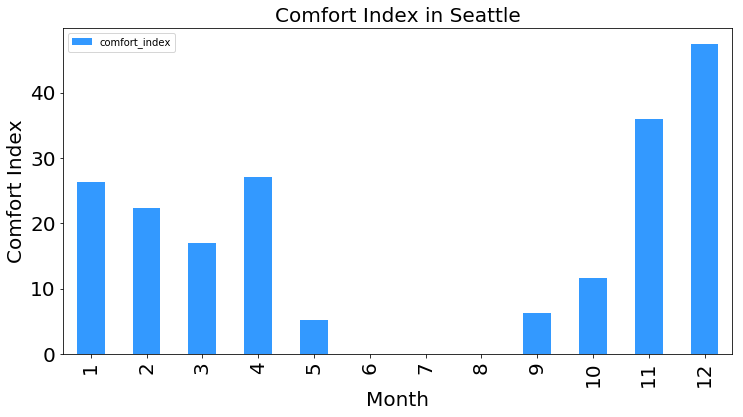

In [40]:
%matplotlib inline

ax = avg_pandas_df.plot(
    kind='bar',
    figsize=(12, 6),
    x='Month',
    y='comfort_index',
    fontsize = 20,
    color='#3399ff',
)
ax.set_xlabel('Month', fontsize = 20)
ax.set_ylabel('Comfort Index', fontsize = 20)
ax.set_title('Comfort Index in Seattle', fontsize = 20)
plt.show()

* June, July, and August are the best month to visit Seattle.
* U.S. News indicates that Summer is the best season to visit Seattle. [source](https://travel.usnews.com/Seattle_WA/When_To_Visit/)

# 4.  **Austin, TX**: "9v6k", "9v67", "9v6s", "9v6e"

![Austin](img/Austin.png)

In [41]:
%%time

df.createOrReplaceTempView("NAM_S")
avg = spark.sql(
    '''
    SELECT
        Month,
        AVG(Humidity) AS Humidity,
        AVG(Temperature) AS Temperature,
        AVG(Wind) AS Wind
    FROM NAM_S
    WHERE Geohash like "9v6k%"
        OR Geohash like "9v67%"
        OR Geohash like "9v6e%"
        OR Geohash like "9v6s%"
    GROUP BY Month
    '''
)

avg.show()

+-----+------------------+------------------+------------------+
|Month|          Humidity|       Temperature|              Wind|
+-----+------------------+------------------+------------------+
|   12| 18.16737288135593| 285.2286548937781| 4.863677225943844|
|    1| 47.92164179104478| 280.7148582116881|5.5317316688041185|
|    6| 40.52281368821293|  300.636720142437| 5.012441954288646|
|    3|46.139146567717994|288.91120381257974| 5.120001183259465|
|    5|  47.2815734989648| 297.5907911217731| 6.684027236070692|
|    9|34.258252427184466| 301.5061148930522| 3.089356507549008|
|    4|  43.0060120240481|295.32095544849466| 6.105264971036472|
|    8|37.014736842105265| 304.9676588199013| 4.129678531508697|
|    7| 27.05103969754253| 303.3916264842273| 7.016817480663722|
|   10| 38.17786561264822|296.01274078731007| 5.366004784057734|
|   11|44.569169960474305| 288.7875494071146| 5.908071092259978|
|    2|43.784679089026916| 283.2984357561384| 6.355180874621152|
+-----+------------------

In [42]:
%%time

# Convert to Pandas dataframe
avg_pandas_df = avg.toPandas()
avg_pandas_df.to_pickle('/home4/csung4/aus.pickle')

CPU times: user 33 ms, sys: 18.3 ms, total: 51.3 ms
Wall time: 2min 30s


In [43]:
avg_pandas_df = pd.read_pickle('/home4/csung4/aus.pickle')

In [44]:
%%time

avg_pandas_df.Temperature = convert_temperature(avg_pandas_df.Temperature)
avg_pandas_df['comfort_index'] = avg_pandas_df.apply(comfort_index, axis=1)
avg_pandas_df.set_index(['Month'])
avg_pandas_df.sort_values('Month', inplace=True)
avg_pandas_df

CPU times: user 3.57 ms, sys: 47 µs, total: 3.62 ms
Wall time: 2.76 ms


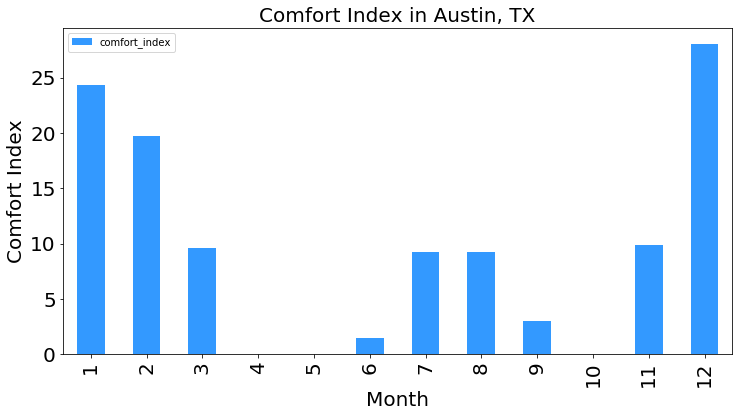

In [45]:
%matplotlib inline

ax = avg_pandas_df.plot(
    kind='bar',
    figsize=(12, 6),
    x='Month',
    y='comfort_index',
    fontsize = 20,
    color='#3399ff',
)
ax.set_xlabel('Month', fontsize = 20)
ax.set_ylabel('Comfort Index', fontsize = 20)
ax.set_title('Comfort Index in Austin, TX', fontsize = 20)
plt.show()

* April, May, and October are the best months to visit Austiin, TX.
* U.S. News indicates that the best times to visit Austin are September to November or March to May. [source](https://travel.usnews.com/Austin_TX/When_To_Visit/)

# 5.  **Chicago**: "dp3w", "dp3t"

![Chicago](img/Chicago.png)

In [46]:
%%time

df.createOrReplaceTempView("NAM_S")
avg = spark.sql(
    '''
    SELECT
        Month,
        AVG(Humidity) AS Humidity,
        AVG(Temperature) AS Temperature,
        AVG(Wind) AS Wind
    FROM NAM_S
    WHERE Geohash like "dp3w%"
        OR Geohash like "dp3t%"
    GROUP BY Month
    '''
)

avg.show()

+-----+------------------+------------------+------------------+
|Month|          Humidity|       Temperature|              Wind|
+-----+------------------+------------------+------------------+
|   12| 67.78402366863905| 277.9385635105111| 7.818096276835577|
|    1| 80.20621468926554| 267.0711760871154| 6.656413058439891|
|    6|48.731988472622476| 293.9814973770713|   4.8498979645435|
|    3| 56.34324324324324|275.28401695457666|  6.61721272162489|
|    5| 59.79692307692308| 289.3773914513221|  6.91504721889129|
|    9| 38.66193181818182|293.17701582475144| 5.003610785373232|
|    4|56.123493975903614|281.03255536182814| 6.836307680301638|
|    8|34.349162011173185| 297.3835722001571| 4.609607744441685|
|    7| 37.83806818181818| 298.0913932106712| 4.762182456017896|
|   10| 54.50852272727273| 286.1508974595503| 7.777343573048711|
|   11| 57.48795180722892| 280.1164863310664| 9.024961322366472|
|    2| 73.72934472934473|  264.189132733902|6.7576931151229775|
+-----+------------------

In [47]:
%%time

# Convert to Pandas dataframe
avg_pandas_df = avg.toPandas()
avg_pandas_df.to_pickle('/home4/csung4/chi.pickle')

CPU times: user 39.2 ms, sys: 19.7 ms, total: 58.8 ms
Wall time: 2min 55s


In [48]:
avg_pandas_df = pd.read_pickle('/home4/csung4/chi.pickle')

In [49]:
%%time

avg_pandas_df.Temperature = convert_temperature(avg_pandas_df.Temperature)
avg_pandas_df['comfort_index'] = avg_pandas_df.apply(comfort_index, axis=1)
avg_pandas_df.set_index(['Month'])
avg_pandas_df.sort_values('Month', inplace=True)
avg_pandas_df

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 12.7 ms


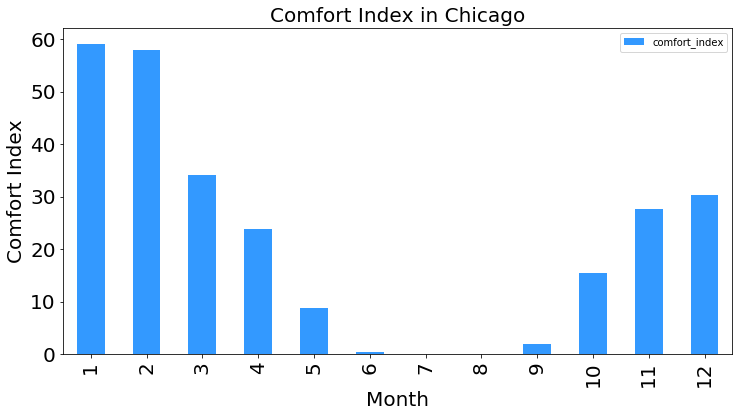

In [50]:
%matplotlib inline

ax = avg_pandas_df.plot(
    kind='bar',
    figsize=(12, 6),
    x='Month',
    y='comfort_index',
    fontsize = 20,
    color='#3399ff',
)
ax.set_xlabel('Month', fontsize = 20)
ax.set_ylabel('Comfort Index', fontsize = 20)
ax.set_title('Comfort Index in Chicago', fontsize = 20)
plt.show()

* July and August are the best months to visit Chicago.
* This [article](https://santorinidave.com/best-time-to-visit-chicago) indicates that the best times to visit Chicago is in late Spring, early summer, and early fall.